In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib as plt

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv")

In [18]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

<Axes: >

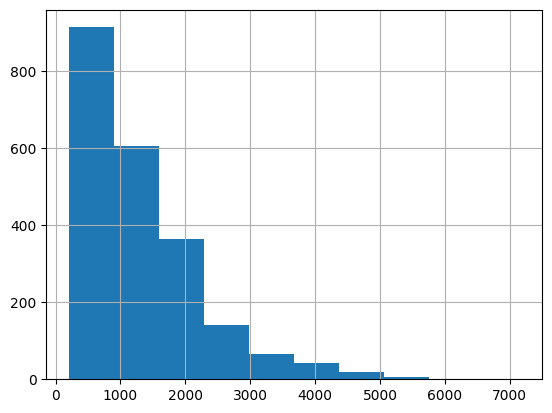

In [19]:
df["final_price"].hist()

# EDA 
Kind of a long taill 

In [20]:
# Q1 What data is missing?
x_df = df[["ram","storage","screen","final_price"]]
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2160 non-null   int64  
 1   storage      2160 non-null   int64  
 2   screen       2156 non-null   float64
 3   final_price  2160 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


# Q2 

What's the median (50% percentile) for variable 'ram'?

In [21]:
x_df.ram.median()

np.float64(16.0)

Prepare and split the dataset

    Shuffle the dataset (the filtered one you created above), use seed 42.
    Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [22]:
def split_dataframe(df, val_ratio=0.2, test_ratio=0.2, random_seed=42):
    """
    Splits a DataFrame into training, validation, and testing sets.

    Parameters:
    - df (pd.DataFrame): The input dataframe to be split.
    - val_ratio (float): The ratio of data to be used for validation.
    - test_ratio (float): The ratio of data to be used for testing.
    - random_seed (int): The random seed for reproducibility.

    Returns:
    - df_train (pd.DataFrame): Training set.
    - df_val (pd.DataFrame): Validation set.
    - df_test (pd.DataFrame): Testing set.
    """
    n = len(df)
    n_val = int(n * val_ratio)
    n_test = int(n * test_ratio)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(random_seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    return df_train, df_val, df_test

In [23]:
df_train, df_val, df_test = split_dataframe(x_df)

# Question 3

    1. We need to deal with missing values for the column from Q1.
        a. We have two options: fill it with 0 or with the mean of this variable.
        b. Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    2. For computing the mean, use the training only!
    3. Use the validation dataset to evaluate the models and compare the RMSE of each option.
    4. Round the RMSE scores to 2 decimal digits using round(score, 2)
    5. Which option gives better RMSE?

Options:

    With 0
    With mean
    Both are equally good

In [33]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X_zerofill(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_meanfill(df, mean):
    df_num = df[base]
    df_num = df_num[['screen']].fillna(mean)
    X = df_num.values
    return X


In [25]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [26]:
base = ["ram","storage","screen"]

# Fill missing values and start with zeros 
X_train = prepare_X_zerofill(df_train)
w0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X_zerofill(df_val)
y_pred = w0 + X_val.dot(w)
rmse_zero = rmse(y_val, y_pred)

round(rmse_zero,2)

np.float64(597.36)

<Axes: ylabel='Count'>

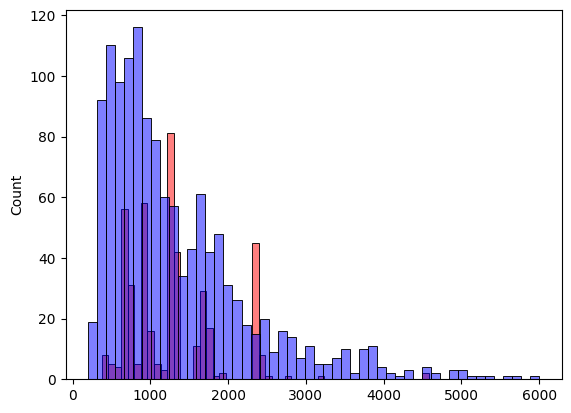

In [27]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [35]:
df_train['screen'].mean()

np.float64(15.163534416086618)

In [37]:
# Fill missing values and use the mean value
screen_mean = df_train['screen'].mean()

X_train = prepare_X_meanfill(df_train, screen_mean)
w0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X_meanfill(df_val, screen_mean)
y_pred = w0 + X_val.dot(w)
rmse_mean = rmse(y_val, y_pred)

round(rmse_mean,2)

np.float64(865.48)

<Axes: ylabel='Count'>

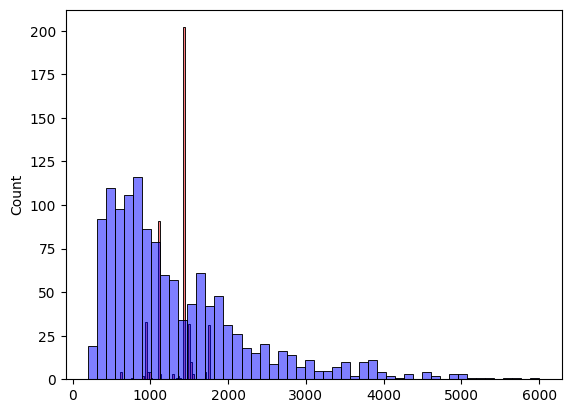

In [38]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

# Question 4

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?

If there are multiple options, select the smallest r.

Options:

    0
    0.01
    1
    10
    100


In [39]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [40]:
rs = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in rs:
    X_train = prepare_X_zerofill(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X_zerofill(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0 676.8954853003995 597.3635593619622
0.01 676.2736817205587 597.3616819856013
0.1 670.7284836314063 597.345159296362
1 619.9030834108207 597.2121215589519
5 463.7771697142356 597.0111186297033
10 352.79713367679835 597.0587680661115
100 66.92071440181994 597.9032640603043


# Question 5

    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    Fill the missing values with 0 and train a model without regularization.
    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    Round the result to 3 decimal digits (round(std, 3))


In [41]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds:

    df_train, df_val, df_test = split_dataframe(x_df, random_seed=seed)
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    X_train = prepare_X_zerofill(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_zerofill(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    scores.append(score)
    
    
    print("Random Seed:", seed, " Bias Term:", w0, " RMSE:",score)

Random Seed: 0  Bias Term: 547.5696230186684  RMSE: 565.4520868771027
Random Seed: 1  Bias Term: 594.41974279991  RMSE: 636.7985423056726
Random Seed: 2  Bias Term: 649.4685454769078  RMSE: 588.9558697907962
Random Seed: 3  Bias Term: 571.945904011273  RMSE: 597.8148920012521
Random Seed: 4  Bias Term: 629.3882030645109  RMSE: 571.962791511102
Random Seed: 5  Bias Term: 580.7647373330074  RMSE: 573.2383256618949
Random Seed: 6  Bias Term: 783.7683689905917  RMSE: 647.3438328407208
Random Seed: 7  Bias Term: 376.4358600624204  RMSE: 550.4398184485952
Random Seed: 8  Bias Term: 572.8852361198617  RMSE: 587.333503616991
Random Seed: 9  Bias Term: 663.3792792607826  RMSE: 576.1017929433108


In [42]:
scores = np.array(scores)

In [43]:
round(np.std(scores),3)

np.float64(29.176)

Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?

Options:

    598.60
    608.60
    618.60
    628.60


In [44]:
# Split the dataset like previously, use seed 9.
df_train, df_val, df_test = split_dataframe(x_df, random_seed=9)
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
# Combine train and validation datasets.
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])
# Fill the missing values with 0 and train a model with r=0.001.
X_full_train = prepare_X_zerofill(df_full_train)
r=0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=r)

X_test = prepare_X_zerofill(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

print(r, w0, score)

0.001 698.4247442538174 608.609982204956
